# 📧 EMAIL SPAM CLASSIFICATION USING NLP

### Step 1: Introduction


🔍 Objective:

To build a model that can automatically classify email or SMS messages as Spam (unwanted) or Ham (legitimate) using Natural Language Processing (NLP) and Machine Learning.

### Step 2: Install and Import Required Libraries

In [11]:
# Install required libraries 
!pip install pandas numpy scikit-learn nltk matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable


### Now import them:

In [14]:
# Importing all necessary libraries

import pandas as pd                 # For data handling
import numpy as np                  # For numerical operations
import matplotlib.pyplot as plt     # For data visualization
import seaborn as sns               # For better visualizations
import nltk                         # For NLP tasks
import re                           # For text cleaning (regular expressions)

# From sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


### Step 3: Load the Dataset

In [17]:
# Load dataset
df = pd.read_csv("spam.csv", encoding='latin-1')

# We only need two columns: v1 (label), v2 (text)
df = df[['v1', 'v2']]
df.columns = ['label', 'text']   # Rename columns for clarity

# Display first few rows
df.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 🧾 Explanation:

The dataset has text messages (in column v2) and their labels (v1 = ham/spam).

We renamed them to label and text for simplicity.

### Check basic info:

In [21]:
df.info()
df['label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


label
ham     4825
spam     747
Name: count, dtype: int64

### This helps us see:

How many spam vs ham messages are there.

If any missing values exist.

### Step 4: Text Cleaning & Preprocessing
Before training our model, we need to clean the text data — removing unnecessary characters, punctuation, etc.

In [25]:
# Download NLTK resources 
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Now we’ll clean the text:

In [28]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1️⃣ Convert to lowercase
    text = text.lower()
    
    # 2️⃣ Remove punctuation, numbers, special characters
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3️⃣ Tokenize (split text into words)
    words = text.split()
    
    # 4️⃣ Remove stopwords and lemmatize (convert to base form)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # 5️⃣ Join words back into a sentence
    return ' '.join(words)

# Apply cleaning to all messages
df['clean_text'] = df['text'].apply(clean_text)

# Display few cleaned texts
df[['text', 'clean_text']].head(10)


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey darling week word back id like fun...
6,Even my brother is not like to speak with me. ...,even brother like speak treat like aid patent
7,As per your request 'Melle Melle (Oru Minnamin...,per request melle melle oru minnaminunginte nu...
8,WINNER!! As a valued network customer you have...,winner valued network customer selected receiv...
9,Had your mobile 11 months or more? U R entitle...,mobile month u r entitled update latest colour...


### Step 5: Encode Labels
Convert text labels (ham/spam) to numbers (0 and 1)

In [32]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()


,label,text,clean_text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...,1
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though,0


### Step 6: Split Data into Train and Test Sets
We’ll use 80% data for training and 20% for testing.

In [36]:
X = df['clean_text']    # Features (emails)
y = df['label_num']     # Labels (0 or 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 4457
Testing samples: 1115


### Explanation:

train_test_split() splits the data randomly.

The model learns from training data, and we test how well it performs on unseen test data.

### Step 7: Convert Text into Numbers (TF-IDF Vectorization)
Text cannot be fed directly into ML models — we need to convert text to numbers.

In [40]:
tfidf = TfidfVectorizer(max_features=3000)  # max_features = top 3000 most frequent words

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


### Explanation:

TF-IDF (Term Frequency–Inverse Document Frequency):

Measures how important a word is in a document.

Words like “win”, “free”, “click” get higher importance in spam emails.

Common words like “the”, “is” get less weight.

### Step 8: Train the Machine Learning Model
We’ll use Multinomial Naive Bayes, a popular algorithm for text classification.

In [44]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

print("✅ Model training completed!")


✅ Model training completed!


### Step 9: Evaluate the Model
Let’s test how well our model performs.

🎯 Accuracy: 0.9730941704035875

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.80      0.89       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



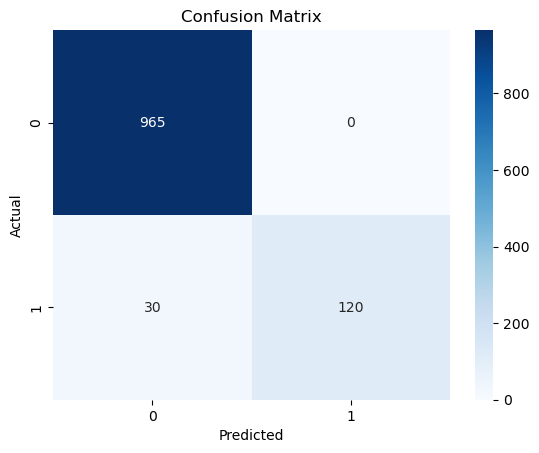

In [47]:
# Predict on test data
y_pred = model.predict(X_test_tfidf)

# Accuracy
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Explanation:

Accuracy: % of correctly classified emails.

Confusion matrix: shows how many spam/ham were correctly or wrongly classified.

Classification report: shows precision, recall, and F1-score.

we should get accuracy between 95–99% .

### Step 10: Test the Model with Your Own Email

In [52]:
# Custom email text
test_email = ["Congratulations! You have won a free iPhone. Click here to claim your prize!"]

# Convert to TF-IDF vector
email_vector = tfidf.transform(test_email)

# Predict
result = model.predict(email_vector)

print("Prediction:", "Spam 🚫" if result[0] == 1 else "Ham ✅")


Prediction: Spam 🚫


### Explanation:

The model converts your input text to numerical form (TF-IDF).

Then it predicts based on the words present — “win”, “click”, “prize” → likely spam.

### Step 11: Save the Model and Vectorizer
We’ll save both the trained model and TF-IDF vectorizer so we can reuse them later without retraining.

In [56]:
import joblib

joblib.dump(model, "email_spam_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("✅ Model and Vectorizer saved successfully!")


✅ Model and Vectorizer saved successfully!
